In [2]:
import os

os.chdir("../")

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
import timm
import numpy as np

import argparse
import torch_optimizer as optimizer
import wandb

from config import settings

import models.spinalnet_resnet as spinalnet_resnet
import models.effnet as effnet
import models.densenet as densenet
import models.spinalnet_vgg as spinalnet_vgg
import models.vitL16 as vitL16
import models.alexnet_vgg as alexnet_vgg
import models.resnet18 as resnet18

import  data
# import data.segmentation as segmentation
# import metrics.metrics as metrics
from data import DataPart
from train import Trainer
import metrics


all_models = [
    ('ResNet18', resnet18.load_model()),
    ('EfficientNet', effnet.load_model()),
    # ('DenseNet', densenet.load_model()),
    # ('SpinalNet_ResNet', spinalnet_resnet.load_model()),
    # ('SpinalNet_VGG', spinalnet_vgg.load_model()),
    # ('ViTL16', vitL16.load_model()),
    # ('AlexNet_VGG', alexnet_vgg.load_model())
]

all_optimizers = [
    ('SGD', optim.SGD),
    ('Rprop', optim.Rprop),
    ('Adam', optim.Adam),
    ('NAdam', optim.NAdam),
    ('RAdam', optim.RAdam),
    ('AdamW', optim.AdamW),
    #('Adagrad', optim.Adagrad),
    ('RMSprop', optim.RMSprop),
    #('Adadelta', optim.Adadelta),
    ('DiffGrad', optimizer.DiffGrad),
    # ('LBFGS', optim.LBFGS)
]

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
datasets, dataloaders = data.create_dataloaders()

train_loader = dataloaders[DataPart.TRAIN]
val_loader = dataloaders[DataPart.VALIDATE]
test_loader = dataloaders[DataPart.TEST_DR5]


/Users/mszekhov/Desktop/current_projects/galaxyHackers/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


INFO: Query finished. [astroquery.utils.tap.core]
252
84
84
244
85


In [3]:

# parser = argparse.ArgumentParser(description='Model training')
# parser.add_argument('--models', nargs='+', default=['ResNet18', 'EfficientNet', 'DenseNet', 'SpinalNet_ResNet', 'SpinalNet_VGG', 'ViTL16', 'AlexNet_VGG'],
#                     help='List of models to train (default: all)')
# parser.add_argument('--epochs', type=int, default=5, help='Number of epochs to train (default: 5)')
# parser.add_argument('--lr', type=float, default=0.0001, help='Learning rate for optimizer (default: 0.0001)')
# parser.add_argument('--mm', type=float, default=0.9, help='Momentum for optimizer (default: 0.9)')
# parser.add_argument('--optimizer', choices=[name for name, _ in all_optimizers], default='Adam', help='Optimizer to use (default: Adam)')

# args = parser.parse_args()

# selected_models = [(model_name, model) for model_name, model in models if model_name in args.models]

# num_epochs = args.epochs
# lr = args.lr
# momentum = args.mm
# optimizer_name = args.optimizer


In [4]:
selected_models = all_models[:2]

num_epochs = 1
lr = 0.0001
momentum = 0.9
optimizer_name = "Adam"




In [5]:
if settings.wandb_api_token:
    wandb.login(key=settings.wandb_api_token)
    wandb.init(project='cluster-search', config={}, reinit=True)
else:
    wandb.init(project='cluster-search', config={}, reinit=True)


wandb.config.models = [name for name, _ in selected_models]
wandb.config.num_epochs = num_epochs
wandb.config.lr = lr
wandb.config.momentum = momentum
wandb.config.optimizer = optimizer_name

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: zehov1 (mzekhov). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/mszekhov/.netrc


In [6]:

# criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()

results = {}
val_results = {}

classes = ('random', 'clusters')


In [7]:
for model_name, model in selected_models:
     optimizer_class = dict(all_optimizers)[optimizer_name]

     if optimizer_name in ['SGD', 'RMSprop']:
          optimizer = optimizer_class(model.parameters(), lr=lr, momentum=momentum) 
     else:
          optimizer = optimizer_class(model.parameters(), lr=lr)
         
     trainer = Trainer(
          model=model,
          criterion=criterion,
          optimizer=optimizer,
          train_dataloader=train_loader,
          val_dataloader=val_loader,

     )

     trainer.train(num_epochs)

     for step in range(trainer.global_step):
          wandb.log(
               {
                    f'{model_name}_{optimizer_name}_train_loss': trainer.history['train_loss'][step], 
                    f'{model_name}_{optimizer_name}_train_accuracy':trainer.history['train_acc'][step], 
                    'global_step': step + 1})
          
     for epoch in range(num_epochs):
          wandb.log(
               {
                    f'{model_name}_{optimizer_name}_val_loss': trainer.history['val_loss'][epoch], 
                    f'{model_name}_{optimizer_name}_val_accuracy': trainer.history['val_acc'][epoch], 
                    'epoch': epoch})

     
     train_table = wandb.Table(
          data=[
               [
                    step, 
                    trainer.history['train_loss'][step], 
                    trainer.history['train_acc'][step]
               ] for step in range(trainer.global_step)],
          columns=["Epoch", "Loss", "Accuracy"])

     val_table = wandb.Table(
          data=[
               [
                    epoch, 
                    trainer.history['val_loss'][epoch], 
                    trainer.history['val_acc'][epoch]
               ] for epoch in range(num_epochs)],
          columns=["Epoch", "Loss", "Accuracy"])

     wandb.log({"Train Metrics": train_table, "Validation Metrics": val_table})

     y_pred, y_probs, y_true, *_ = trainer.test(test_loader)

     metrics.modelPerformance(model_name, optimizer_name, y_true, y_pred, y_probs, classes)


 69%|██████▉   | 11/16 [07:45<03:31, 42.33s/batch]        | 0/1 [00:00<?, ?epoch/s]


KeyboardInterrupt: 

In [8]:
wandb.finish()

wandb_run = wandb.run
if wandb_run:
    logged_metrics = wandb_run.history()
    print("Logged Metrics:")
    for key, value in logged_metrics.items():
        print(key, ":", value)
else:
    print("No wandb run found.")

ResNet18_Adam_train_accuracy,▆▆▅▆▆▆▇▇▇█▇▇▇▇█▁
ResNet18_Adam_train_loss,█▇█▇▇▇▅▅▅▄▆▅▃▂▁▇
ResNet18_Adam_val_accuracy,▁
ResNet18_Adam_val_loss,▁
epoch,▁
global_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
ResNet18_Adam_train_accuracy,0.0
ResNet18_Adam_train_loss,0.6936
ResNet18_Adam_val_accuracy,0.72852
ResNet18_Adam_val_loss,0.62251
epoch,0


No wandb run found.


In [9]:
import segmentation

from importlib import reload
reload(data)
reload(segmentation)

<module 'segmentation' from '/Users/mszekhov/Desktop/current_projects/galaxyHackers/segmentation.py'>

In [2]:
import os
os.chdir("../")
from config import settings



In [3]:
os.getcwd()

'/Users/mszekhov/Desktop/current_projects/galaxyHackers'

In [6]:
from importlib import reload
reload(segmentation)

<module 'segmentation' from '/Users/mszekhov/Desktop/current_projects/galaxyHackers/segmentation.py'>

100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


2
2
2
2
2
2
2
2
2
2


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


ValueError: [[0.80756235 0.86470556 0.72454673 0.7589087  0.7059749 ]
 [0.6842229  0.73802453 0.5097177  0.56521875 0.6264294 ]
 [0.672332   0.6800857  0.70485455 0.5637165  0.5717845 ]
 [0.5889962  0.6097769  0.65194887 0.5365998  0.51562876]
 [0.7622784  0.8653867  0.7724491  0.65028995 0.5624696 ]]

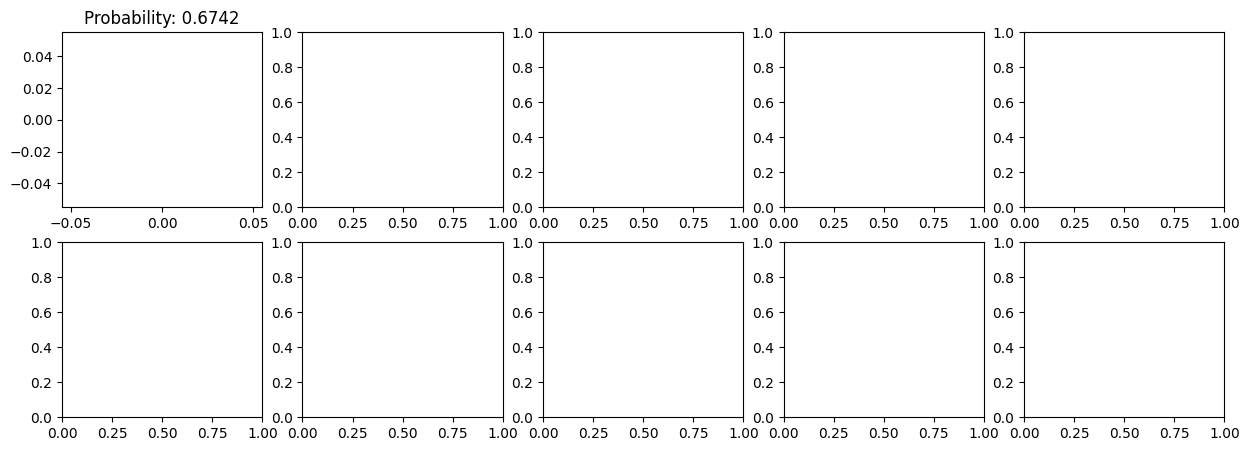

In [7]:
import segmentation
import traceback

model_name, model = selected_models[0]
segmentation.create_segmentation_plots(
    model,
    model_name,
    optimizer_name=optimizer_name
)

In [20]:
n_rows = 2
n_cols = 5
for i in range(10):   
    cur_row = i // n_cols
    cur_col = i % n_cols
    print(cur_row, cur_col)

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4


In [24]:
import traceback

traceback.format_exc()

'NoneType: None\n'

In [15]:
import data
from config import settings

dataset = data.ClusterDataset(
        "/Users/mszekhov/Desktop/current_projects/galaxyHackers/storage/segmentation/samples/cluster/758",
        "/Users/mszekhov/Desktop/current_projects/galaxyHackers/storage/segmentation/samples/cluster/758/description.csv",
        transform=transforms.Compose(data.main_transforms),
    )

dataloader = DataLoader(dataset, batch_size=settings.BATCH_SIZE)

In [17]:
[str(i) if i%2 else i for i in range(10)]

[0, '1', 2, '3', 4, '5', 6, '7', 8, '9']

In [16]:
for batch in dataloader:
    print(batch.keys())
    raise

batch

dict_keys(['idx', 'image'])


RuntimeError: No active exception to reraise

In [ ]:
фю

In [17]:
batch

{'idx': ['0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '10',
  '11',
  '12',
  '13',
  '14',
  '15',
  '16',
  '17',
  '18',
  '19',
  '20',
  '21',
  '22',
  '23',
  '24',
  '25',
  '26',
  '27',
  '28',
  '29',
  '30',
  '31',
  '32',
  '33',
  '34',
  '35',
  '36',
  '37',
  '38',
  '39',
  '40',
  '41',
  '42',
  '43',
  '44',
  '45',
  '46',
  '47',
  '48',
  '49',
  '50',
  '51',
  '52',
  '53',
  '54',
  '55',
  '56',
  '57',
  '58',
  '59',
  '60',
  '61',
  '62',
  '63'],
 'image': tensor([[[[-1.6555, -1.6555, -1.6384,  ..., -1.6213, -1.6213, -1.6213],
           [-1.6555, -1.6555, -1.6384,  ..., -1.6213, -1.6213, -1.6213],
           [-1.6555, -1.6555, -1.6384,  ..., -1.6213, -1.6213, -1.6213],
           ...,
           [-1.6898, -1.6898, -1.6898,  ..., -1.6898, -1.6898, -1.6898],
           [-1.6898, -1.6898, -1.6898,  ..., -1.6898, -1.6898, -1.6898],
           [-1.6898, -1.6898, -1.6898,  ..., -1.6898, -1.6898, -1.6898]],
 
          [[-1.5980, -1.

In [10]:
selected_models[0]

('ResNet18',
 ResNet18(
   (resnet): ResNet(
     (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (layer1): Sequential(
       (0): BasicBlock(
         (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu): ReLU(inplace=True)
         (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       )
       (1): BasicBlock(
         (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, moment